In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set_style('white')

In [ ]:
df = pd.read_csv('North_ML_ready.csv')
df

,CODUFMUN,COMPETEN,SUICIDE,POP_EST,RATE,CONSELHO_SOCIAL_ASSISTANT,TP_UNID_SPECIALIZED_HOSPITAL,TIPEQUIP_OTHER,SGRUPHAB_ODONTOLOGY,TP_UNID_SHORTSTAY_HOSPITAL,SGRUPHAB_GENETICS,SGRUPHAB_MENTAL_HEALTH,CONSELHO_PHYSICAL_EDUCATION,TIPEQUIP_DENTISTRY,SERV_ESP_REHABILITATION,TP_UNID_NOTIFICATION_CENTER,TP_UNID_PHARMACY,CONSELHO_PHYSICIST,CONSELHO_OPTICIAN,NULEITOS,SERV_ESP_REPRODUCTIVE_HEALTH,SGRUPHAB_URGENCY,SERV_ESP_PHYSICALTHERAPY,SGRUPHAB_CHRONIC_DISEASES,TIPO_EQP_ORAL_HEALTH,SERV_ESP_OBESITY,SERV_ESP_MENTAL_HEALTH,SGRUPHAB_CARDIOVASCULAR,TIPEQUIP_AUDIOLOGY,CONSELHO_PHARMACIST,CONSELHO_VETERINARIAN,SERV_ESP_HEMOTHERAPY,SGRUPHAB_INTERMEDIARY_CARE,SERV_ESP_ONCOLOGY,SERV_ESP_ORAL_HEALTH,SGRUPHAB_PHYLANTHROPY,SERV_ESP_NUTRITION/GASTROLOGY,SERV_ESP_TELEHEALTH,SGRUPHAB_OPHTHALMOLOGY,SERV_ESP_URGENCY,CONSELHO_MEDICAL_REGISTRATION_MAIS_MEDICOS,TP_UNID_MULTISPECIALIST_CLINIC,SERV_ESP_RARE_DISEASES,CONSELHO_PSYCHOLOGIST,SERV_ESP_ENDOCRINOLOGY,SERV_ESP_SEXUAL_VIOLENCE,TIPEQUIP_GRAPHIC_METHODS,TP_UNID_PREVENTION_CENTER,SERV_ESP_TEACHING,TP_UNID_HEALTHCARE_SURVEILLANCE,SERV_ESP_HEARING_HEALTH,TP_UNID_SPECIALIZED_EMERGENCY_ROOM,TP_UNID_MIXED_EMERGENCY_UNIT,CONSELHO_NURSING,CONSELHO_PEDAGOGY,Leitos,TP_UNID_EMERGENCY_CARE,TP_UNID_EDUCATIONAL_CENTER,TP_UNID_DIAGNOSTIC_CENTER,TP_UNID_CLINIC,SERV_ESP_COMMITTIEES,AMB_SUS,TP_UNID_MULTISPECIALIST_PRIMARY_HEALTHCARE,TIPO_EQP_MENTAL_HEALTH,TIPO_EQP_PRISION_HEALTH,TP_UNID_FAMILY_CENTER,TP_UNID_INDIGENOUS_CENTER,TP_UNID_GENERAL_HOSPITAL,CONSELHO_RADIOLOGY_TECHNICIAN,CONSELHO_RADIOLOGIST,TP_UNID_CENTRAL_LABORATORY,SGRUPHAB_HIV/AIDS,TIPO_EQP_HEALTH_AGENTS,SGRUPHAB_TRAUMA,SERV_ESP_PHARMACY,SGRUPHAB_AURICULAR,HOSP_SUS,SERV_ESP_TUBERCULOSIS/HANSENS_DISEASES,TP_UNID_PRIMARY_HEALTHCARE_UNIT,TP_UNID_RIVER_MOBILE_UNIT,TP_UNID_HOME_CARE,TP_UNID_HEALTH_INSURANCE,IND_SUS,TIPEQUIP_IMAGE_DIAGNOSIS,SGRUPHAB_ONCOLOGY,SERV_ESP_SMOKING,SERV_ESP_INDIGENOUS_HEALTH,PROF_SUS,SERV_ESP_NEUROLOGY,SERV_ESP_TRANSPLANT,TIPEQUIP_LIFE_MAINTAINING,SGRUPHAB_ORTHOPEDICS,TP_UNID_MOBILE_URGENCY_CARE,SERV_ESP_NEFROLOGY,SERV_ESP_PRISON,SGRUPHAB_ICU,SERV_ESP_ORTHOPEDICS,TIPEQUIP_OPTICAL_METHODS,CONSELHO_BIOMEDICINE,TP_UNID_TELEHEALTH,TP_UNID_ACCESS_CENTER,SGRUPHAB_WORKER_HEALTHCARE,TP_UNID_GENERAL_EMERGENCY_ROOM,SGRUPHAB_NUTRITION_GASTROLOGY,CONSELHO_NUTRITIONIST,TIPO_EQP_INDIGENOUS_HEALTH,CONSELHO_PHYSIOTHERAPIST_OCCUPATIONAL_THERAPIST,CONSELHO_SPEECH_THERAPIST,TP_UNID_HEALTH_DEPARTMENT,SGRUPHAB_SURGERY,SERV_ESP_SURGERY,CONSELHO_PHYSICIAN,CONSELHO_CHEMIST,TIPO_EQP_FAMILY_HEALTH,SGRUPHAB_NEUROLOGY,TP_UNID_HEALTHCARE_REGULATOR,SERV_ESP_PREGNANCY,TP_UNID_IMMUNIZATION_CENTER,SERV_ESP_OPHTHALMOLOGY,TP_UNID_MOBILE_HEATH_CARE,SGRUPHAB_PREGNANCY,SERV_ESP_BASIC_HEALTH,SERV_ESP_IMUNIZATION,SGRUPHAB_NEPHROLOGY,TIPO_EQP_PRIMARY_CARE,CONSELHO_DENTIST,TP_UNID_PUBLIC_HEALTH_LABORATORY,TP_UNID_PSYCOSOCIAL_CENTER,SERV_ESP_STI/HIV/AIDS,VINC_SUS,TP_UNID_URGENCY_CARE_REGULATOR,SERV_ESP_ADOLESCENT_HEALTH,SERV_ESP_PNEUMOLOGY,SERV_ESP_CARDIOVASCULAR,CONSELHO_BIOLOGIST,SERV_ESP_HEALTH_SURVEILLANCE,CNES,TP_UNID_SUPPLY_CENTER,CONSELHO_ECONOMIST,TP_UNID_SPECIALIST_UNIT,SGRUPHAB_TEACHING,TIPEQUIP_INFRASTRUCTURE,SERV_ESP_DIAGNOSIS,SERV_ESP_TRANSSEXUAL,SGRUPHAB_TRANSPLANT,SERV_ESP_ICU,TP_UNID_HEMOTHERAPY_CENTER,CONSELHO_STATISTICIAN,SGRUPHAB_GERIATRIC,SGRUPHAB_PHYSICAL_REHABILITATION,SGRUPHAB_OBESITY,TP_UNID_CHILDBIRTH_CENTER,RATE_SUICIDE
0,110001,200907,1,22516,4.441286,0,0,1,0,0,0,1,0,14,0,0,0,0,0,0,2,0,4,0,2,0,1,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,69,0,0,3,0,0,11,6,0,0,0,0,2,0,0,0,0,2,0,0,0,3,2,2,0,0,0,3,3,0,1,2,0,0,0,2,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,6,0,0,4,0,2,0,0,10,0,0,0,0,0,1,0,11,0,0,0,0,0,1,41858723,0,0,0,0,2,18,0,0,0,0,0,0,0,0,0,0
1,110001,201106,1,22516,4.441286,0,0,0,0,0,0,1,0,15,0,0,0,0,0,0,2,0,4,0,2,0,1,0,0,0,0,0,0,0,1,0,2,0,0,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,54,0,0,3,0,0,9,6,0,2,0,0,2,0,0,0,0,2,0,0,0,3,3,2,0,0,0,3,3,0,1,2,0,0,0,3,0,0,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,6,0,0,4,0,2,0,0,8,0,0,0,0,0,1,0,12,0,0,0,0,0,1,5458

### Train and Test sets

In [ ]:
y = df['RATE_SUICIDE']
# removing some columns equivalent to the outcome or that are specific
X = df.drop(columns= ['RATE_SUICIDE', 'CODUFMUN', 'COMPETEN', 'SUICIDE', 'RATE', 'NULEITOS', 'CNES', 'POP_EST',
                      'CONSELHO_ECONOMIST', 'CONSELHO_STATISTICIAN', 'HOSP_SUS', 'AMB_SUS', 'IND_SUS', 'CONSELHO_VETERINARIAN',
                      'CONSELHO_MEDICAL_REGISTRATION_MAIS_MEDICOS','CONSELHO_PHYSICIST']).sort_index(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.2, random_state=0)

In [ ]:
print(f'Training set size - {len(X_train)}')
print(f'\nTest set size - {len(X_test)}')

Training set size - 6365

Test set size - 1592


In [ ]:
print("Class proportion in the original set:")
print(y.value_counts(normalize=True))

print("\nClass proportion in the training set")
print(y_train.value_counts(normalize=True))

print("\nClass proportion in the test set")
print(y_test.value_counts(normalize=True))

Class proportion in the original set:
RATE_SUICIDE
0    0.774664
1    0.137866
2    0.087470
Name: proportion, dtype: float64

Class proportion in the training set
RATE_SUICIDE
0    0.774705
1    0.137785
2    0.087510
Name: proportion, dtype: float64

Class proportion in the test set
RATE_SUICIDE
0    0.774497
1    0.138191
2    0.087312
Name: proportion, dtype: float64


## XGBoost

### Hyperparameter tuning

In [ ]:
xg = XGBClassifier(eval_metric='mlogloss')

In [ ]:
%%time
# Defining the hyperparameter distribution

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
param_dist = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [1000, 3000],
    'classifier__subsample': [0.6, 1.0],
    'classifier__colsample_bytree': [0.6, 1.0],
    'classifier__max_depth': [5, 10, 15],
    'classifier__gamma': [0, 1, 5],
    'classifier__min_child_weight': [1, 5, 10],
}

# Initialize lists to store results
all_y_true = []
all_y_pred = []
best_params_list = []  # Store best parameters for each fold

for train_index, test_index in kf.split(X_train, y_train):  # Stratify by y
    X_tr, X_val = X.iloc[train_index], X.iloc[test_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[test_index]

    # oversampling
    pipeline = Pipeline([
        ('oversample', RandomOverSampler(random_state=3)),
        ('classifier', xg)
    ])

    # Tuning
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=10,
        scoring='accuracy',  # Choose appropriate scoring metric
        cv=5,  # Inner cross-validation folds for RandomizedSearchCV
        n_jobs=-1  # Use all available CPU cores
    )

    # Fit RandomizedSearchCV on training data
    random_search.fit(X_tr, y_tr)

    # Get the best model and predictions
    best_xg = random_search.best_estimator_
    y_pred = best_xg.predict(X_val)

    # Store results
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
    best_params_list.append(random_search.best_params_)

CPU times: user 11min 9s, sys: 4.3 s, total: 11min 13s
Wall time: 19min 10s


In [ ]:
print(f'{best_params_list[0]}\n\n{best_params_list[1]}\n\n{best_params_list[2]}\n\n{best_params_list[3]}\n\n{best_params_list[4]}\n')
# Extracting values for each parameter
max_depth = [params['classifier__max_depth'] for params in best_params_list]
learning_rate = [params['classifier__learning_rate'] for params in best_params_list]
subsample = [params['classifier__subsample'] for params in best_params_list]
n_estimators = [params['classifier__n_estimators'] for params in best_params_list]
colsample_bytree = [params['classifier__colsample_bytree'] for params in best_params_list]
gamma = [params['classifier__gamma'] for params in best_params_list]
min_child_weight = [params['classifier__min_child_weight'] for params in best_params_list]

# Calculate mean values
mean_max_depth = np.mean(max_depth)
learning_rate = np.mean(learning_rate)
subsample = np.mean(subsample)
mean_n_estimators = np.mean(n_estimators)
colsample_bytree = np.mean(colsample_bytree)
gamma = np.mean(gamma)
min_child_weight = np.mean(min_child_weight)

# Print the mean values
print(f"max_depth= {mean_max_depth:.0f},")
print(f"learning_rate= {learning_rate:.2f},")
print(f"subsample= {subsample:.2f},")
print(f"colsample_bytree= {colsample_bytree:.2f},")
print(f"n_estimators= {mean_n_estimators:.0f}")
print(f"gamma= {gamma:.0f}")
print(f"min_child_weight= {min_child_weight:.0f}")

{'classifier__subsample': 1.0, 'classifier__n_estimators': 1000, 'classifier__min_child_weight': 1, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0, 'classifier__colsample_bytree': 1.0}

{'classifier__subsample': 0.6, 'classifier__n_estimators': 3000, 'classifier__min_child_weight': 10, 'classifier__max_depth': 15, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.6}

{'classifier__subsample': 0.6, 'classifier__n_estimators': 3000, 'classifier__min_child_weight': 5, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0, 'classifier__colsample_bytree': 1.0}

{'classifier__subsample': 0.6, 'classifier__n_estimators': 1000, 'classifier__min_child_weight': 1, 'classifier__max_depth': 15, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.6}

{'classifier__subsample': 0.6, 'classifier__n_estimators': 1000, 'classifier__min_child_weight': 

### Prediction

In [ ]:
%%time
xg = XGBClassifier(max_depth=15,
                   learning_rate=0.05,
                   subsample=0.6,
                   colsample_bytree=1,
                   n_estimators=1000,
                   gamma=1,
                   min_child_weight=1,
                   eval_metric='mlogloss'
                  )

eval_set = [(X_test, y_test)]

xg.fit(X_train, y_train,
          eval_set=eval_set,
          verbose=False)

CPU times: user 27.9 s, sys: 184 ms, total: 28.1 s
Wall time: 15.7 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_true = y_test
y_pred = y_pred
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97      1233
     class 1       0.80      0.75      0.77       220
     class 2       0.93      0.84      0.88       139

    accuracy                           0.94      1592
   macro avg       0.90      0.86      0.88      1592
weighted avg       0.94      0.94      0.94      1592



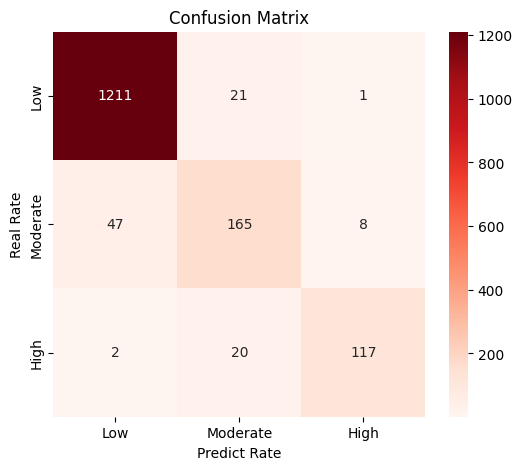

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Criando o gráfico de calor (heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Low", "Moderate", "High"], yticklabels=["Low", "Moderate", "High"])
plt.xlabel("Predict Rate")
plt.ylabel("Real Rate")
plt.title("Confusion Matrix")
plt.savefig(fname='ConfusionMatrix_North.png', dpi=300, format='png',bbox_inches='tight')
plt.show()

In [ ]:
# Showing the feature importance
importances = xg.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

print("Features and their importances:")
for index in sorted_indices:
    print(f"{X.columns[index]}: {importances[index]*100:.2f}%")

Features and their average importances:
VINC_SUS: 8.58%
TIPEQUIP_IMAGE_DIAGNOSIS: 5.95%
SERV_ESP_DIAGNOSIS: 5.16%
SERV_ESP_BASIC_HEALTH: 4.79%
CONSELHO_PHYSICIAN: 3.95%
SERV_ESP_PREGNANCY: 3.94%
Leitos: 3.80%
TP_UNID_MULTISPECIALIST_PRIMARY_HEALTHCARE: 3.63%
TIPEQUIP_LIFE_MAINTAINING: 3.54%
PROF_SUS: 2.98%
TIPEQUIP_INFRASTRUCTURE: 2.76%
CONSELHO_NURSING: 2.71%
SERV_ESP_MENTAL_HEALTH: 2.50%
TIPEQUIP_DENTISTRY: 2.17%
TIPO_EQP_HEALTH_AGENTS: 2.12%
TIPEQUIP_GRAPHIC_METHODS: 1.95%
CONSELHO_PHARMACIST: 1.93%
TP_UNID_PRIMARY_HEALTHCARE_UNIT: 1.88%
CONSELHO_DENTIST: 1.83%
TP_UNID_PSYCOSOCIAL_CENTER: 1.75%
TP_UNID_GENERAL_HOSPITAL: 1.69%
TP_UNID_SPECIALIST_UNIT: 1.68%
SERV_ESP_URGENCY: 1.45%
CONSELHO_RADIOLOGY_TECHNICIAN: 1.44%
TIPO_EQP_ORAL_HEALTH: 1.35%
SERV_ESP_ORAL_HEALTH: 1.34%
CONSELHO_SOCIAL_ASSISTANT: 1.24%
CONSELHO_PHYSIOTHERAPIST_OCCUPATIONAL_THERAPIST: 1.17%
SERV_ESP_TUBERCULOSIS/HANSENS_DISEASES: 1.16%
SERV_ESP_PHYSICALTHERAPY: 1.15%
SERV_ESP_HEMOTHERAPY: 1.05%
TIPEQUIP_OPTICAL_METH

### Correlations of variables with rate

We used the 10 most important variables to see how they correlate with the suicide rate in the region. We used the spearman correlation since data are not normal or de correlation may not be linear.

In [ ]:
from scipy.stats import kstest

statistic, p_value = kstest(y, 'norm')  # 'norm' specifies the normal distribution
print(f'Kolmogorov-Smirnov Test: Statistic = {statistic:.3f}, p-value = {p_value:.3f}\n')

if p_value > 0.05:
    print('Data appears to be normally distributed.')
else:
    print('Data does not appear to be normally distributed.)')

Kolmogorov-Smirnov Test: Statistic = 0.500, p-value = 0.000

Data does not appear to be normally distributed.)


In [ ]:
features = ['RATE',
'VINC_SUS',
'TIPEQUIP_IMAGE_DIAGNOSIS',
'SERV_ESP_DIAGNOSIS',
'SERV_ESP_BASIC_HEALTH',
'CONSELHO_PHYSICIAN',
'SERV_ESP_PREGNANCY',
'Leitos',
'TP_UNID_MULTISPECIALIST_PRIMARY_HEALTHCARE',
'TIPEQUIP_LIFE_MAINTAINING',
'PROF_SUS'
             ]


rename = {'RATE':'Suicide Rate',
'VINC_SUS':'SUS establishments',
'PROF_SUS':'SUS professionals',
'CONSELHO_PHYSICIAN':'Physicians',
'Leitos':'Hospital beds',
'SERV_ESP_BASIC_HEALTH':'Basic health services',
'SERV_ESP_PREGNANCY':'Pregnancy care',
'SERV_ESP_DIAGNOSIS':'Diagnostic services',
'TP_UNID_MULTISPECIALIST_PRIMARY_HEALTHCARE':'Multispecialty primary unit',
'TIPEQUIP_IMAGE_DIAGNOSIS':'Image diagnostic equipment',
'TIPEQUIP_LIFE_MAINTAINING':'Life support equipment'
          }

sim = sim[features].rename(columns=rename)
sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7957 entries, 0 to 7956
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Suicide Rate                 7957 non-null   float64
 1   SUS establishments           7957 non-null   int64  
 2   Image diagnostic equipment   7957 non-null   int64  
 3   Diagnostic services          7957 non-null   int64  
 4   Basic health services        7957 non-null   int64  
 5   Physicians                   7957 non-null   int64  
 6   Pregnancy care               7957 non-null   int64  
 7   Hospital beds                7957 non-null   int64  
 8   Multispecialty primary unit  7957 non-null   int64  
 9   Life support equipment       7957 non-null   int64  
 10  SUS professionals            7957 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 683.9 KB


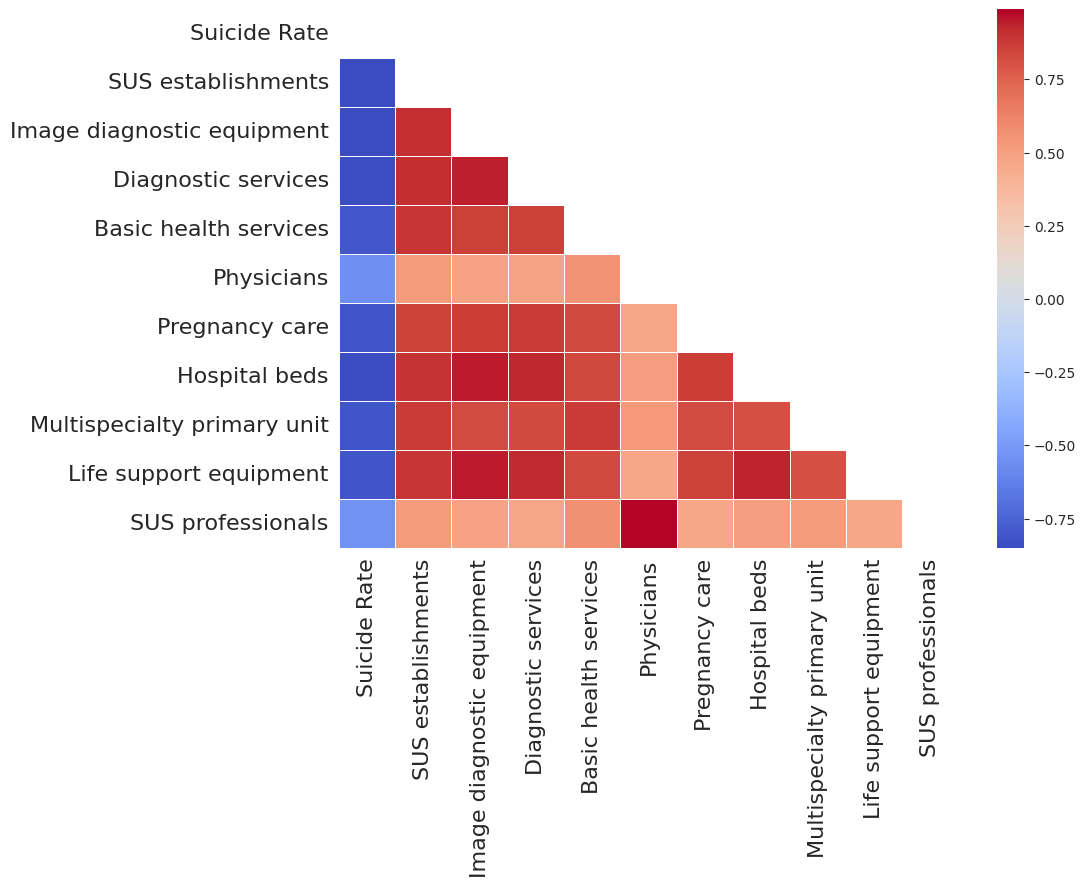

In [ ]:
# correlation matrix of all variables
corr = sim.corr(method='spearman')

# removing the upper triangle because it is mirrored
mask = np.triu(np.ones_like(corr, dtype= bool))
f, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(corr, mask= mask, linewidth= 0.5, cmap='coolwarm',);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()